<a href="https://colab.research.google.com/github/Vasu-Rocks/AI-ML-Project/blob/main/AI%26MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

# Mount with Drive & Loading the dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn (1).csv")

# Check basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Path to dataset files: /kaggle/input/telco-customer-churn
Dataset shape: (7043, 21)

First few rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No    

In [2]:
# 1. Preprocess the Data
# Identify target variable
print("\nChurn distribution:")
print(df['Churn'].value_counts(normalize=True))

# Handle categorical variables using one-hot encoding
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns = [col for col in categorical_columns if col != 'customerID']
print("\nCategorical columns for one-hot encoding:", categorical_columns)

# Remove non-predictive columns
df = df.drop(['customerID'], axis=1, errors='ignore')

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
print("\nDataset shape after one-hot encoding:", df_encoded.shape)

# Prepare features and target
X = df_encoded.drop('Churn', axis=1) if 'Churn' in df_encoded.columns else df_encoded.drop('Churn_Yes', axis=1)
y = df_encoded['Churn'] if 'Churn' in df_encoded.columns else df_encoded['Churn_Yes']

# Scale numerical features
scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'Churn']
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Split the dataset into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Categorical columns for one-hot encoding: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']

Dataset shape after one-hot encoding: (7043, 6560)

Training set shape: (4930, 6559)
Testing set shape: (2113, 6559)


In [3]:
# 2. Feature Selection & Model Training
# Perform feature selection using LASSO regularization (L1 penalty)
print("\nPerforming LASSO feature selection...")
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_train, y_train)
model_lasso = SelectFromModel(lasso, prefit=True, threshold=1e-5)
X_train_selected = model_lasso.transform(X_train)
X_test_selected = model_lasso.transform(X_test)

# Get selected feature names
selected_features_mask = model_lasso.get_support()
selected_features = X.columns[selected_features_mask].tolist()
print(f"\nSelected {len(selected_features)} features out of {X.shape[1]}:")
print(selected_features)

# Map the indices back to the original features for better interpretation
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(lasso.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nTop 10 features by importance:")
print(feature_importance.head(10))

# Train logistic regression model on selected features with class weights
print("\nTraining logistic regression model...")
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train_selected, y_train)


Performing LASSO feature selection...

Selected 11 features out of 6559:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Dependents_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'TechSupport_Yes', 'Contract_One year', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check']

Top 10 features by importance:
                           Feature  Importance
1                           tenure    0.139670
27  PaymentMethod_Electronic check    0.086775
2                   MonthlyCharges    0.075006
9      InternetService_Fiber optic    0.066727
25            PaperlessBilling_Yes    0.042644
23               Contract_One year    0.037068
18                 TechSupport_Yes    0.036383
12              OnlineSecurity_Yes    0.034143
0                    SeniorCitizen    0.018106
5                   Dependents_Yes    0.007173

Training logistic regression model...


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

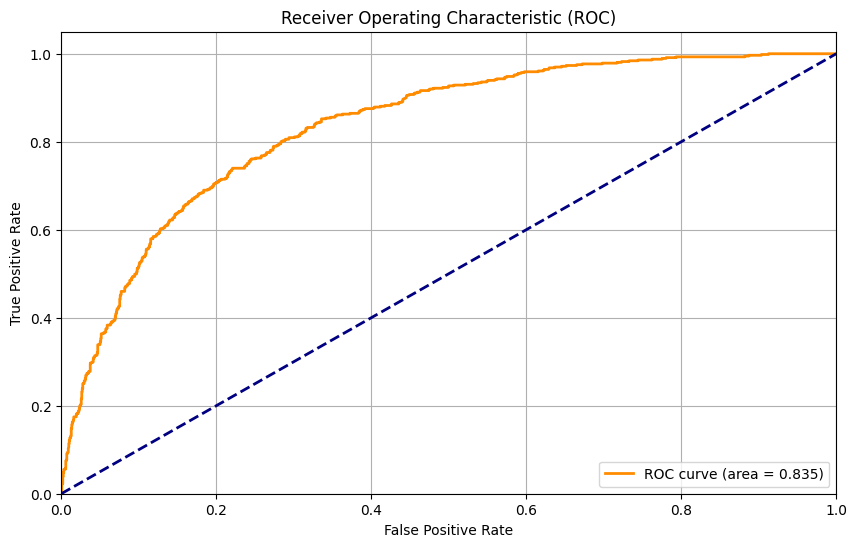


AUC Score: 0.835


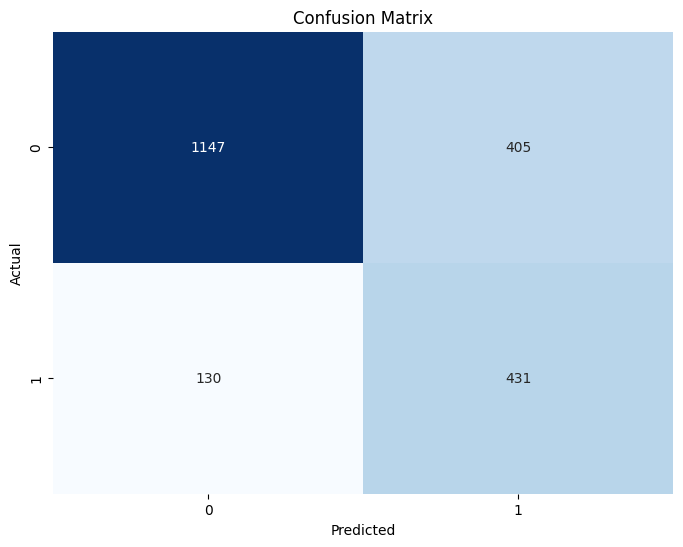


Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.74      0.81      1552
        True       0.52      0.77      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.75      0.71      2113
weighted avg       0.80      0.75      0.76      2113


Top 10 features by odds ratio:
                           Feature  Coefficient  Odds_Ratio
4      InternetService_Fiber optic     0.599754    1.821670
10  PaymentMethod_Electronic check     0.475549    1.608897
9             PaperlessBilling_Yes     0.433613    1.542822
2                   MonthlyCharges     0.303772    1.354960
0                    SeniorCitizen     0.091688    1.096022
3                   Dependents_Yes    -0.334968    0.715361
8                Contract_One year    -0.347050    0.706770
7                  TechSupport_Yes    -0.495065    0.609531
6               OnlineSecurity_Yes    -0.518396    0.595475
1                

In [4]:
# 3. Evaluation & Interpretation
# Predict on test set
y_pred_prob = logreg.predict_proba(X_test_selected)[:, 1]
y_pred = logreg.predict(X_test_selected)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nAUC Score: {roc_auc:.3f}")

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Report precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Interpret the odds ratios
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': logreg.coef_[0],
    'Odds_Ratio': np.exp(logreg.coef_[0])
})
coef_df = coef_df.sort_values('Odds_Ratio', ascending=False)
print("\nTop 10 features by odds ratio:")
print(coef_df.head(10))
print("\nBottom 10 features by odds ratio:")
print(coef_df.tail(10))

# Extract contract-related features for specific analysis
contract_features = [feat for feat in selected_features if 'Contract' in feat]
if contract_features:
    contract_df = coef_df[coef_df['Feature'].isin(contract_features)]
    print("\nAnalysis of Contract Types and their impact on churn:")
    print(contract_df)

    # Business implications
    print("\nBusiness Implications of Contract Types:")
    for index, row in contract_df.iterrows():
        feature = row['Feature']
        odds = row['Odds_Ratio']
        if odds > 1:
            print(f"- {feature} increases churn probability by {(odds-1)*100:.2f}%")
        else:
            print(f"- {feature} decreases churn probability by {(1-odds)*100:.2f}%")
else:
    print("\nNo contract features were selected by the LASSO model.")